# 0660836 - Dhananjaya

# Requirements

1. Implement EEGNet and DeepConvNet with three kinds of actication function (i.e. ReLU, LeakyReLU, ELU)
2. Show the highest accuracy of two architectures with three actication functions
3. Visualize the accuracy trend during training and testing phase

# Introduction

EEG (Electroencephalography) is an electrophysical monitoring method to record electrical activity of the brain. EEG signals are used to monitor brain activities and brain related diseases.

In this lab, I implemented different CNN architectures (i.e. EEGNet, DeepConvNet) with three type of activation functions namely ReLU, LeakyReLU and ELU to perform EEG classification task and compare the performances.

## Dataset
EEG-data is recorded from three different subjects during a BCI experiment. The experiment consists of 3 sessions for each subject. The EEG signals were sampled with 125 Hz, it was filtered between 0.5 - 30 Hz with notchfilter on.

![](img/dataset.PNG)
<h4><center> Fig: EEG Dataset with two channels </center></h1> 

# Experimental Setup

## EEGNet
EEGNet consists of three layers. First layer is a 2D convolution layer functions as feature extractor outputting feature maps form the EEG signals at different bandpass frequencies. Second layer, DepthwiseConv2D to learn a spatial filter, reducing the number of trainable parameters. Finally, third layer SeparableConv2D learns the temporal summary for each feature map individually followed by pointwise convolution which earns how to optimally mix the feature maps together.

![](img/eegnet.PNG)
<h4><center> Fig: EEGNet architecture </center></h1> 

## DeepConvNet
DeepConvNet is a CNN based architecture consists of multiple stacked convolution layers with activation layers, pooling layers.
![](img/cnn.PNG)
<h4><center> Fig: Example of DeepConvNet architecture </center></h1> 

In [27]:
class EEGNet(nn.Module):
    def __init__(self, activation_name='ELU', dropout_ratio=0.5):
        super(EEGNet, self).__init__()
        self.activation_name = activation_name
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1), padding=(0,25), bias=False),
            nn.BatchNorm2d(16),
        )
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1,1), groups=16, bias=False),
            get_activation_function(activation_name),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.separable_conv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32),
            get_activation_function(activation_name),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8), padding=0), 
            nn.Dropout(p=dropout_ratio),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        
    def forward(self, x):
        out = self.conv_1(x)
        out = self.depthwise_conv(out)
        out = self.separable_conv(out)
        out = out.view(-1, 736) # flattern
        out = self.classifier(out)
        return out
    
    def get_activation_name(self):
        return self.activation_name

net = EEGNet(activation_name='ReLU')
x = torch.randn((64, 1, 2, 750))
out = net(x)
print(out.shape)
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters:',params)

torch.Size([64, 2])
Number of parameters: 17810


In [29]:
class DeepConvNet(nn.Module):
    def __init__(self, activation_name='ELU',dropout_ratio=0.5):
        super(DeepConvNet, self).__init__()
        self.activation_name = activation_name
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), bias=True),
            nn.Conv2d(25, 25, kernel_size=(2, 1), bias=True),
            nn.BatchNorm2d(25),
            get_activation_function(activation_name),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), bias=True),
            nn.BatchNorm2d(50),
            get_activation_function(activation_name),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), bias=True),
            nn.BatchNorm2d(100),
            get_activation_function(activation_name),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.conv_4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), bias=True),
            nn.BatchNorm2d(200),
            get_activation_function(activation_name),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.fc = nn.Linear(8600, 2)
        
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        out = self.conv_3(out)
        out = self.conv_4(out)
        out = out.view(x.shape[0], -1)
        out = self.fc(out)
        return out
    
    def get_activation_name(self):
        return self.activation_name

    
net = DeepConvNet(activation_name='ReLU')
x = torch.randn((1, 1, 2, 750))
out = net(x)

model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters',params)

Number of parameters 150977


## Activation Function

ReLU (Rectified Linear Unit) is the popular choice of hidden unit because of nonlinear in nature and any function can be approximated with combinations of ReLU. It is also computationally efficient due to the simpler mathematical operations. The demerit of the RelU is that the vanishing gradient in negative area which results in zeroing the updating parameters.

LeakyReLU have a small slope instead of zero in the negative part of the axis. ELU (Exponential Linear Units) is also another choice which have small gradient but will saturate when input is more negative. Practically, LeakyReLU and ELU is more computationally intensive than ReLU.

![](img/activation.PNG)
<h4><center> Fig: Different Activation Functions </center></h1> 

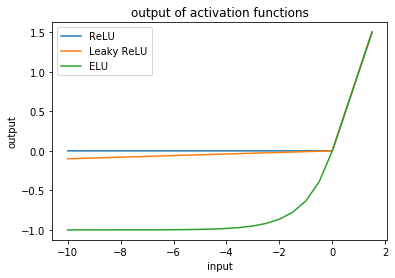

# Experimental Result

## Training Setting
I trained the EEGNet with batch size of 256 for 800 epochs. SGD optimizer is used with a momentum of 0.5 and the initial learning rate is set to 0.1.

For DeepConvNet, I use batch size of 128 for 800 epochs with a learning rate of 0.05 and SGD optimizer with a momentum of 0.5.

## Accuracy
Accuraccy of 88.33% was acheived with LeakyRelu as an activation function.  EEGNet contains 17.8k tunable parameters whereas DeepConvNet contains 150k tunable parameters.

| - | EEGNet | DeepConvNet |
| --- | --- | --- |
|Parameters|17.8k|150k|

Hyperparameter setting:
- number of epochs: 800
- batch size: 256 (EEGNet), 128 (DeepConvNet)
- learning rate: 0.1 (EEGNet), 0.05 (DeepConvNet)
- optimizer: SGD with momentum of 0.5
- criterion(loss): CrossEntropy

| Activation | EEGNet | DeepConvNet |
| --- | --- | --- |
| ReLU | 87.81% | 77.96% |
| LeakyReLU | 88.33% | 79.25% |
| ELU | 81.66 | 79.81% |

### Highest Accuracy Plots
![](img/eeg_highest.PNG)
<h4><center> Fig: Highest testing accuracy of 88.33%  </center></h1>

![](img/deep_highest_80_8.PNG)
<h4><center> Fig: Highest testing accuracy of 79.44%  </center></h1>

## Accuracy Trend

Different architecture (i.e EEGNet, DeepConvNet) yields varied range of test accuracies with different activation functions (i.e. ReLU, LeakyReLU, ELU). LeakyReLU as an activation function on EEGNet achieves the highest accuracy of 88.33% while other activation function on EEGNet gives substantial accuracies. LeakyReLU on DeepConvNet achieves highest accuracy of 79.81% while other activation function gave reduced accuracies.

![](img/eeg_activation.PNG)
<h4><center> Fig: Accuracies of EEG Network with different activation function </center></h1>

![](img/deep_activation.PNG)
<h4><center> Fig: Accuracies of DeepConvNet Network with different activation function </center></h1>

# Discussion

For better results, I fine tuned the parameters using grid search.

| Activation | Dropout | Epoch Size|Batch Size| Learning Rate|Momentum|Test Accuracy|
| --- | --- | --- | --- |--- | --- | --- | 
| LeakyReLU | 0.55 | 833 |320|0.45|0.11|88.05|
| LeakyReLU | 0.55 | 833 |192|0.01|0.77|87.12|
| ReLU | 0.66 | 833 |224|0.12|0.12|87.03|
| LeakyReLU | 0.55 | 833 |224|0.45|0.55|88.5|
| LeakyReLU | 0.44 | 1100 |160|0.23|0.22|88.4|

The EEGNet outperforms DeepConvNet with LeakyReLU as acitvation function because EEGNet architecture is application specific for EEG signal related applications. Moreover, the hyperparameter grid search has not been performed for DeepConvNet. So, its not lag behind EEGNet if we select the right parameters.

## Dropout Influence

The dropout method is used in both the archtiectures. If dropout rate will be lower, more number of inputs bog down to zero whereas higher dropout will cause reduced test accuracy. So, there always a tradeoff between selecting a dropout rate. In our grid search results with ReLU as activation function, it shows that an optimum dropout rate lies between 0.44 - 0.55.

![](img/dropout_relu.PNG)
<h4><center> Fig: Network to implement </center></h1>

# Back-Propagation Through Time (BPTT)

Below is the mathematical derivation for BPTT.

![](img/a.jpg)
<h4><center> Fig: Derivation (Part 1) </center></h1>

![](img/b.jpg)
<h4><center> Fig: Derivation (Part 2) </center></h1>

![](img/c.jpg)
<h4><center> Fig: Derivation (Part 3) </center></h1>

![](img/d.jpg)
<h4><center> Fig: Derivation (Part 4) </center></h1>

![](img/e.jpg)
<h4><center> Fig: Derivation (Part 5) </center></h1>